In [1]:
import pandas as pd
import itertools

import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
from statsmodels.tsa.arima_process import arma_generate_sample
import warnings
import pickle
from tqdm import tqdm

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
class Nasdaq_Consituent :
    """
        Define the list of nasdaq consituent for a certain year or even day (for futur work)
        Data : From WRDS -> Compustats and 1990 to 2023
    """
    def __init__(self, file_path)-> None:
        self.data = pd.read_csv(file_path)
        
    def list_nasdaq_constituents_by_year(self, year: int = 2023) -> list:
        """
        List all NASDAQ constituents for a given year based on the dataset, with cleaned ticker symbols.

        Parameters:
        data (DataFrame): The DataFrame containing NASDAQ constituents data.
        year (int): The year for which to list the constituents.

        Returns:
        list: A list of tickers that were NASDAQ constituents in the given year, with no suffixes.
        """
        # Convert 'from' and 'thru' columns to datetime
        self.data['from'] = pd.to_datetime(self.data['from'])
        self.data['thru'] = pd.to_datetime(self.data['thru'])

        # Filter data for the specified year
        constituents = self.data[(self.data['from'].dt.year <= year) & (self.data['thru'].isna() | (self.data['thru'].dt.year >= year))]

        # Clean the ticker symbols and get the unique list
        tickers = constituents['co_tic'].unique().tolist()
        return tickers
    

    def create_nasdaq_constituents_daily(self) -> list:
        """
        Create a dictionary where each key is a date and the value is a list of tickers that were NASDAQ 100 constituents on that date.

        Parameters:
        data (DataFrame): The DataFrame containing NASDAQ constituents data.

        Returns:
        dict: A dictionary with dates as keys and lists of tickers as values.
        """
        # Convert 'from' and 'thru' columns to datetime
        self.data['from'] = pd.to_datetime(self.data['from'])
        self.data['thru'] = pd.to_datetime(self.data['thru']).fillna(pd.Timestamp('today'))

        # Initialize an empty dictionary
        constituents_dict = {}

        # Iterate over each row in the DataFrame
        for index, row in self.data.iterrows():
            # Generate a date range for each row
            date_range = pd.date_range(start=row['from'], end=row['thru'])

            for date in date_range:
                # Convert date to string format for dictionary key
                date_str = date.strftime('%Y-%m-%d')
                
                # Add the ticker to the corresponding date in the dictionary
                if date_str in constituents_dict:
                    constituents_dict[date_str].add(row['co_tic'])
                else:
                    constituents_dict[date_str] = {row['co_tic']}

        # Convert sets to lists for each date
        for date in constituents_dict:
            constituents_dict[date] = list(constituents_dict[date])

        return constituents_dict


def f_load_adjPrice(filepath) -> pd.DataFrame:
    """
        Load pandas dataframe of the price series

    Args:
        filepath (str): Filepath to the adjPrice_nasdaq100.csv
    """
    
    try:
        adjPrice = pd.read_pickle(filepath)
        adjPrice.index = adjPrice["date"]
    except Exception as e:
        print("Error : {e}")
        adjPrice = None
    return adjPrice


def f_selectTicker(tickerList, adjPrice)-> pd.DataFrame:
    """ 
    Select the columns that are in tickerList

    Args:
        tickerList (list): List of all tickers to take into considerations
        adjPrice (pd.DataFrame): Adjusted price of all tickers
    """
    
    return adjPrice.loc[:, adjPrice.columns.isin(tickerList)]

def f_insample_outsample(data, year):
    data.index = pd.to_datetime(data.index)
    # Select in-sample data: data from the four years prior to the specified year.
    # It checks if the year in the data is less than the specified year
    # and greater than or equal to four years before the specified year.
    in_sample = data[(data.index.year < year) & (data.index.year >= year - 4)]
    
    # Select out-sample data: data from the specified year but only for the first six months.
    # It checks if the year in the data is exactly the specified year and
    # if the month is less than or equal to 6 (January to June).
    out_sample = data[(data.index.year == year) & (data.index.month <= 6)]

    # Return both the in-sample and out-sample datasets.
    return in_sample, out_sample


def pairDatabase(consituentList : list) -> pd.DataFrame:
    
    combinations = [(a, b) for a, b in itertools.permutations(consituentList, 2)]

    # Create a DataFrame
    pairDatabase = pd.DataFrame(combinations, columns=["Stock 1", "Stock 2"])
    pairDatabase["pair"] = pairDatabase["Stock 1"] + "/" + pairDatabase["Stock 2"]
    
    return pairDatabase


## PCI Class

In [3]:
class partial_cointegration:
    
    def __init__(self, X1, X2):
        self.X1 = X1
        self.X2 = X2

    def fit_pci(self, tol=0.001):
        '''
        Fit partial cointegrated model to time series X1 and X2 such that:
            - X_2,t = alpha + beta * X_1,t + W_t
            - W_t = M_t + R_t
            - M_t = rho * M_t-1 + eps(M_t)
            - R_t = R_t-1 + eps(R_t)
            - eps(M_t) ∼ NID(0, sigma_M)
            - eps(R_t) ∼ NID(0, sigma_R)

        Parameters:
        X1 (numpy.ndarray): time series
        X2 (numpy.ndarray): time series, supposedly partially cointegrated with X1

        Returns:
        alpha (float): estimated value for alpha
        beta (float): estimated value for beta
        rho (float): estimated AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): estimated white noise variance of mean reverting component .
        sigma_R (float): estimated white noise variance of random walk component.
        '''

        # calculate initial guess for beta
        results = self.fit_ols_on_diff()
        beta_i = results

        # calculate initial guess for alpha
        alpha_i = self.X2[0] - beta_i * self.X1[0]

        # calculate residuals W and initial guesses for rho, sigma_M, sigma_R
        W = self.X2 - alpha_i - beta_i * self.X1

        params_i = self.fit_mle(W)

        rho, sigma_M, sigma_R = params_i
        
        # perform optimization depending on the mode (Complete Model)
        x_i = (alpha_i, beta_i, rho, sigma_M, sigma_R)  # initial guess
        res = opt.minimize(self.f_to_min_pci, x_i, args=(self.X1, self.X2), tol=tol)
        alpha, beta, rho, sigma_M, sigma_R = res.x
        ll_model = -res.fun
        
        
        # perform optimization for the random Walk H0)
        # perform optimization depending on the mode (Complete Model)
        x_i = (alpha_i, beta_i, sigma_R)  # initial guess
        res = opt.minimize(self.f_to_min_pci, x_i, args=(self.X1, self.X2), tol=tol)
        ll_randomWalk = -res.fun
        
        W = self.X2 - alpha - beta * self.X1

        return alpha, beta, rho, sigma_M, sigma_R, ll_model, ll_randomWalk, W
    

    def fit_mle(self, W, tol=0.001):
        '''
        fit model using Maximum Likelihood estimation. This is used on the residuals W_t of the linear regression of X1 on X2.

        Parameters:
        X (numpy.ndarray): A partial suspected autoregressive time series

        Returns:
        rho (float): estimated value of rho
        sigma_M (float): estimated value of sigma_M
        sigma_R (float): estimated value of sigma_R
        '''

        estimates = []
        lls = []

        # distribution for random guesses
        rnd_rho = stats.uniform(loc=-1, scale=2)

        # get initial guesses using lagged variances
        x_i = self.lagvar_estimate_par(W)

        # set boundaries
        bounds = ((-1, 1), (0, np.inf), (0, np.inf))

        # function to generate random initial values
        std = np.std(np.diff(W))
        rnd_sigma = stats.norm(loc=std, scale=std / 2)

        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs(), rnd_sigma.rvs()

        # minimize
        res = opt.minimize(self.f_to_min_par , x0=(x_i), args=(W), bounds=bounds, tol=tol)

        if res.success:
            estimates.append(res.x)
            lls.append(-res.fun)  # save log-likelihood

        # repeat minimization with different (random) initial values
        n_att = 0
        while len(lls) < 10 and n_att < 100:
            n_att += 1
            x0 = gen_x0()
            res = opt.minimize(self.f_to_min_par, x0=(x0), args=(W), bounds=bounds, tol=tol)
            if res.success:
                estimates.append(res.x)
                lls.append(-res.fun)  # save log-likelihood

        try:
            argmax = np.argmax(lls)  # index of the biggest likelihood
            return estimates[argmax]
        except:
            # print('Estimation failed!')
            return len(x0) * [np.nan]  # return nans
        
        

    def lagvar_estimate_par(self, W):
        '''
        estimate parameters of partial AR model using lagged variances. used for inital estimation of parameters

        Parameters
        X (numpy.ndarray): A partial autoregressive time series

        Returns:
        rho_lv (float): estimated value for rho
        sigma_M_lv (float): estimated value for sigma_M
        sigma_R_lv (float): estimated value for sigma_R
        '''

        # calculate lagged variances
        v1 = np.var(W[1:] - W[:-1])
        v2 = np.var(W[2:] - W[:-2])
        v3 = np.var(W[3:] - W[:-3])

        # rho
        rho_lv = -(v1 - 2 * v2 + v3) / (2 * v1 - v2)

        # sigma_M
        if (rho_lv + 1) / (rho_lv - 1) * (v2 - 2 * v1) > 0:
            sigma_M_lv = np.sqrt(1 / 2 * (rho_lv + 1) / (rho_lv - 1) * (v2 - 2 * v1))
        else:
            sigma_M_lv = 0

        # sigma_R
        if v2 > 2 * sigma_M_lv ** 2:
            sigma_R_lv = np.sqrt(1 / 2 * (v2 - 2 * sigma_M_lv ** 2))
        else:
            sigma_R_lv = 0

        return rho_lv, sigma_M_lv, sigma_R_lv

    def fit_ols_on_diff(self):
        '''
        Fits an OLS model on the first differences of time series X1 and X2

        Parameters:
        X1 (numpy.ndarray): A time-series
        X2 (numpy.ndarray): A time-series

        Returns:
        results.params[0]: returns the Beta value of our OLS fit
        '''
        ret_X1 = np.diff(self.X1)
        ret_X2 = np.diff(self.X2)

        results = sm.OLS(ret_X2, ret_X1).fit()

        return results.params[0]

    def kalman_estimate(self, W, rho, sigma_M, sigma_R):
        '''
        Calculate estimates of mean-reverting and random walk components.

        Parameters:
        X (numpy.ndarray): A partial autoregressive time series
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        M (numpy.ndarray): An estimate of the mean reverting component of our time series
        R (numpy.ndarray): An estimate of the random walk component of our time series
        eps (numpy.ndarray): Prediction errors for each time step
        '''

        # create arrays for storing both components and prediction errors
        M = np.zeros(len(W))
        R = np.zeros(len(W))
        eps = np.zeros(len(W))

        # set initial state
        if sigma_R == 0:
            M[0] = W[0]
            R[0] = 0
        else:
            M[0] = 0
            R[0] = W[0]

        # calculate Kalman gain
        if sigma_M == 0:
            K_M = 0
            K_R = 1
        elif sigma_R == 0:
            K_M = 1
            K_R = 0
        else:
            sqr = np.sqrt((1 + rho) ** 2 * sigma_R ** 2 + 4 * sigma_M ** 2)
            K_M = 2 * sigma_M ** 2 / (sigma_R * (sqr + rho * sigma_R + sigma_R) + 2 * sigma_M ** 2)
            K_R = 2 * sigma_R / (sqr - rho * sigma_R + sigma_R)

        # calculate estimates
        for i in range(1, len(W)):
            xhat = rho * M[i - 1] + R[i - 1]
            eps[i] = W[i] - xhat
            M[i] = rho * M[i - 1] + eps[i] * K_M
            R[i] = R[i - 1] + eps[i] * K_R

        return M, R, eps

    def calc_log_like(self, W, rho, sigma_M, sigma_R):
        '''
        Compute log likelihood function

        Parameters:
        X (numpy.ndarray): A partial autoregressive time series
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        ll (float): Value of the log likelihood, a measure of goodness of fit for our model
        '''

        N = len(W)
        _, _, eps = self.kalman_estimate(W, rho, sigma_M, sigma_R)
        ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
                2 * (sigma_M ** 2 + sigma_R ** 2)) * np.sum(eps[1:] ** 2)

        return ll

    def f_to_min_par(self, x_i, W):
        rho, sigma_M, sigma_R = x_i
        '''
        Define the function to minimize for PAR model
        '''
        return -self.calc_log_like(W, rho, sigma_M, sigma_R)

    def f_to_min_pci(self, x_i, X1, X2):
        '''
        Define function to minimize
        '''
        if len(x_i) == 5 :
            alpha, beta, rho, sigma_M, sigma_R = x_i
            
        elif len(x_i) == 3:
            alpha, beta, sigma_R = x_i
            rho = 0
            sigma_M = 0
        
        W = X2 - beta * X1 - alpha
        return -self.calc_log_like(W, rho, sigma_M, sigma_R)

In [4]:
def Rsquare(sigmaM, sigmaR, rho):
    return 2 * (sigmaM ** 2) / (2 * (sigmaM ** 2) + (1+rho) * sigmaR ** 2)


def rolling_z_score(series, window):
    """
    Calculate the rolling Z-score of a given time series.
    
    Parameters:
    series (pd.Series): The time series data.
    window (int): The size of the rolling window.
    
    Returns:
    pd.Series: A series of rolling Z-scores.
    """
      # Convert numpy array to pandas Series if necessary
    if isinstance(series, np.ndarray):
        series = pd.Series(series)

    # Calculate rolling mean and standard deviation
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    # Calculate the Z-score
    z_score = (series - rolling_mean) / rolling_std

    return z_score


### Retreive the adjPrice selon la liste des constituents

In [5]:
# Load adjPrice for all tickers
filepath1 = "/Users/sebastiencaron/Desktop/PCI-Project/strategyV1/data/adjPrice_nasdaq100.pkl"
adjPrice = f_load_adjPrice(filepath1)


# Load the CSV file : Compustat daily consituent
filepath2 = '/Users/sebastiencaron/Desktop/PCI-Project/strategyV1/data/NasdaqConstituent.csv'
object_nasdaq = Nasdaq_Consituent(filepath2)
# Liste des consituents pour une certaine année

year = 2008
consituent2008 = object_nasdaq.list_nasdaq_constituents_by_year(year)

# Get price series for list of tickers
df_2008 = f_selectTicker(consituent2008, adjPrice)

# Split In and Out sample
df_2008_in_sample, df_2008_out_sample = f_insample_outsample(df_2008, year)

# Get the In and Out sample 
df_2008_inout = pd.concat([df_2008_in_sample, df_2008_out_sample])

# Save in stock prices dictionnary
stockPrices = {"inSample": df_2008_in_sample,
               "outSample": df_2008_out_sample}

# Get the list of consituent of price that we have
consituentList = df_2008_in_sample.columns.tolist()



In [6]:
# Generate all possible permutations of pairs (including reversed pairs)
pairData = pairDatabase(consituentList=consituentList)
pairData

,Stock 1,Stock 2,pair
0,AABA,AAPL,AABA/AAPL
1,AABA,ADBE,AABA/ADBE
2,AABA,ADP,AABA/ADP
3,AABA,ADSK,AABA/ADSK
4,AABA,AKAM,AABA/AKAM
...,...,...,...
13335,XRAY,WBD,XRAY/WBD
13336,XRAY,WCRX,XRAY/WCRX
13337,XRAY,WFM,XRAY/WFM
13338,XRAY,WYNN,XRAY/WYNN


#### Get elligibility metrics + etimators

In [7]:
# Find Parameters for each pair
def f_get_elligibility(Stock1, Stock2, inSample):
        
    X = inSample[[Stock1, Stock2]].dropna()

    X1 = X[Stock1]
    X2 = X[Stock2]

    coint = partial_cointegration(X1, X2)
    alpha_hat, beta_hat, rho_hat, sigma_M_hat, sigma_R_hat, ll_model, ll_randomWalk, W_hat = coint.fit_pci()
    # M_hat, R_hat, _ = coint.kalman_estimate(W_hat, rho_hat, sigma_M_hat, sigma_R_hat)

    Rsquare_res = Rsquare(sigma_M_hat, sigma_R_hat, rho_hat)
    ll_ratio = np.log(ll_randomWalk / ll_model)
    # print([ll_randomWalk, ll_model])
    
    return {"elligibility":[rho_hat, Rsquare_res, ll_ratio],
            "estimators" :[alpha_hat, beta_hat, rho_hat, sigma_M_hat, sigma_R_hat]}

#### itterate through each pair and store result

In [8]:
# Take 15 hours  
"""
def f_compute_estimate(pairName: pd.DataFrame, inSample: pd.DataFrame)-> tuple :
    N = len(pairName)
    elligibilityData = np.zeros((N, 3))
    estimationData = np.zeros((N, 5))
    
    for pair in tqdm(N, desc="Processing Pairs"):
        try:
            pairName_i = pairName[pair]
            # print(f"Doing : {pairName_i}")
            Stock1 = pairData["Stock 1"][pair]
            Stock2 = pairData["Stock 2"][pair]
            
            dict_res = f_get_elligibility(Stock1, Stock2, inSample)
            elligibilityData[pair] = dict_res["elligibility"]
            # latentVariablesData[pairName[pair]] = dict_res["latentVariables"]
            estimationData[pair] = dict_res["estimators"]
            #print(f"{pairName_i}: Done")
        except Exception as e: 
            print(f"Error with {pairName_i} and {e}")
        # saving files in pickle format 
        
    with open('elligibilityData.pkl', 'wb') as file:
        pickle.dump(elligibilityData, file)

    with open('estimationData.pkl', 'wb') as file:
        pickle.dump(estimationData, file)
            
    return elligibilityData, estimationData
    
    
pairName = pairData["pair"]
inSample = stockPrices["inSample"]

elligibilityData, estimationData = f_compute_estimate(pairName, inSample)
    
"""


'\ndef f_compute_estimate(pairName: pd.DataFrame, inSample: pd.DataFrame)-> tuple :\n    N = len(pairName)\n    elligibilityData = np.zeros((N, 3))\n    estimationData = np.zeros((N, 5))\n    \n    for pair in tqdm(N, desc="Processing Pairs"):\n        try:\n            pairName_i = pairName[pair]\n            # print(f"Doing : {pairName_i}")\n            Stock1 = pairData["Stock 1"][pair]\n            Stock2 = pairData["Stock 2"][pair]\n            \n            dict_res = f_get_elligibility(Stock1, Stock2, inSample)\n            elligibilityData[pair] = dict_res["elligibility"]\n            # latentVariablesData[pairName[pair]] = dict_res["latentVariables"]\n            estimationData[pair] = dict_res["estimators"]\n            #print(f"{pairName_i}: Done")\n        except Exception as e: \n            print(f"Error with {pairName_i} and {e}")\n        # saving files in pickle format \n        \n    with open(\'elligibilityData.pkl\', \'wb\') as file:\n        pickle.dump(elligibilit

#### Conversion des arrays en dataframe

In [9]:
# Dataframe des pairs élligibiles
def f_create_dataframe(elligibilityData: pd.DataFrame, estimationData: pd.DataFrame, pairName: pd.DataFrame)-> tuple:
    
    elligibilityData = pd.DataFrame(elligibilityData, index = pairName, columns=["rho", "Rsquare", "ll_ratio"])
    elligibilityData["ll_ratio"].fillna(0)
    elligibility_sorted_data = elligibilityData[
                                                (elligibilityData["rho"] > 0.5) &
                                                (elligibilityData["rho"] < 0.9) &  
                                                (elligibilityData["Rsquare"] > 0.5) & 
                                                (elligibilityData["ll_ratio"] > 0) &
                                                (elligibilityData["ll_ratio"] < 1)
                                            ].sort_values(by="ll_ratio", ascending=True)
    # Dataframe des paramètres estimés
    estimatorData = pd.DataFrame(estimationData, index = pairName, columns=["alpha_hat", "beta_hat", "rho_hat", "sigma_M_hat", "sigma_R_hat"])
    
    return elligibility_sorted_data, estimatorData

#### Creation du dataframe pre-trading (Shares for each stock, and more...)

In [10]:
def f_get_pre_trading(pairSelected : str, pairData: pd.DataFrame, data: pd.DataFrame, estimatorData : list, window: int = 30) -> pd.DataFrame:

    tmp = pairData[pairData["pair"] == pairSelected]
    Stock1 = tmp['Stock 1'].iloc[0]
    Stock2 = tmp['Stock 2'].iloc[0]

    X = data[[Stock1, Stock2]].dropna()

    X1 = X[Stock1]
    X2 = X[Stock2]

    alpha_hat, beta_hat, rho_hat, sigma_M_hat, sigma_R_hat = estimatorData

    W = X2 - alpha_hat - beta_hat * X1

    coint = partial_cointegration(X1, X2)

    M_hat, R_hat, _ = coint.kalman_estimate(W, rho_hat, sigma_M_hat, sigma_R_hat)

    M_hat_reindexed = pd.Series(M_hat, index = X.index)
    
    
    pre_trading = pd.DataFrame({
                            "PStock1": X1,
                            "PStock2" : X2,
                            "hedgeRatio" : beta_hat / X2,
                            "zScore" : rolling_z_score(M_hat_reindexed, window)
                            }, index = X.index)
    # Create tau : Treshold


    # Step 1: Create τ column based on zScore
    pre_trading['tau'] = 0  # Initialize tau with 0
    pre_trading.loc[(pre_trading['zScore'] > 1) & (pre_trading['zScore'].shift(1) < 1), 'tau'] = 1

    # Condition for tau == -1: previous zScore was above -0.5 and current is below -0.5
    pre_trading.loc[(pre_trading['zScore'] < -0.5) & (pre_trading['zScore'].shift(1) > -0.5), 'tau'] = -1

    pre_trading["Share1"] = np.nan
    pre_trading["Share2"] = np.nan

    pre_trading["Share1"][0] = 0
    pre_trading["Share2"][0] = 0

    closePosition = (pre_trading['tau'] == -1)
    openPosition = (pre_trading['tau'] == 1)

    pre_trading["Share1"][openPosition] = pre_trading['hedgeRatio'][openPosition].values
    pre_trading["Share2"][openPosition] = (-1 / pre_trading['PStock2'][openPosition].values)

    pre_trading["Share1"][closePosition] = 0
    pre_trading["Share2"][closePosition] = 0

    # Fill NaN values with the last non-NaN value
    pre_trading["Share1"].fillna(method='ffill', inplace=True)
    pre_trading["Share2"].fillna(method='ffill', inplace=True)

    # PnL : Variation of Price effect and amount of share
    PnL1 = (pre_trading["PStock1"].shift(-1).values - pre_trading["PStock1"].values) * pre_trading["Share1"]
    PnL2 = (pre_trading["PStock2"].shift(-1).values - pre_trading["PStock2"].values) * pre_trading["Share2"]

    # Le PnL est capté le jours suivant au close
    pre_trading["PnL1"] = PnL1.shift().fillna(0)
    pre_trading["PnL2"] = PnL2.shift().fillna(0)
    pre_trading["PnL"] = pre_trading["PnL1"] + pre_trading["PnL2"]

    plt.plot(pre_trading["PnL"].cumsum())
    
    return pre_trading


#### Create for each pair selected a pre_trading dataframe
1. list of pair selected
2. dictionnary for each pair selected
3. pre_trading for each pair
4. Aggregate position in portfolio

In [11]:

def f_get_portfolio_positions(elligibility_sorted_data: pd.DataFrame, top_pct: float, pairData: pd.DataFrame, df_2008_inout: pd.DataFrame, estimatorData: pd.DataFrame, window : int = 30) -> tuple:
    
    # Trouver le nombre de pair elligible
    n_elligible = len(elligibility_sorted_data.index)
    
    # Selon le pourcentage de pair quon select
    n = max(1, round(top_pct * n_elligible))
    pairListSelected = elligibility_sorted_data.index[:n].tolist()
    
    # Get the amount of unique stocks
    unique_stocks = pairData.loc[pairData["pair"].isin(pairListSelected), ["Stock 1", "Stock 2"]].stack().unique().tolist()

    # initialiser le dictionnaire pre_trading
    pre_trading_dict = {key : None for key in pairListSelected}

    # initialiser le dataframe des positions pour chaque stock
    portfolio_Shares = pd.DataFrame(np.zeros((len(df_2008_inout.index), len(unique_stocks))), index = df_2008_inout.index, columns = unique_stocks)

    # ittérer à travers chaque portefeuille
    for pair in pairListSelected:
        
        estimators = estimatorData.loc[pair].tolist()
        pre_trading = f_get_pre_trading(pair, pairData, df_2008_inout, estimators,  window)
        pre_trading_dict[pair] = pre_trading
        
        # Create portfolio of Share for every stock
        Stock1 = pairData.loc[pairData["pair"] == pair, "Stock 1"].iloc[0]
        Stock2 = pairData.loc[pairData["pair"] == pair, "Stock 2"].iloc[0]
        
        Share1 = pre_trading["Share1"]
        Share2 = pre_trading["Share2"]
        
        portfolio_Shares[Stock1] += Share1
        portfolio_Shares[Stock2] += Share2
    
    return pre_trading_dict, portfolio_Shares
    

## Code A to Z

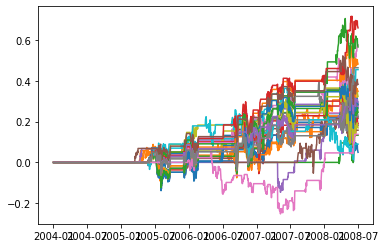

In [12]:
# Load adjPrice for all tickers
filepath1 = "/Users/sebastiencaron/Desktop/TradingClubHFT/Codes/Cointegration/data/adjPrice_nasdaq100.pkl"
adjPrice = f_load_adjPrice(filepath1)


# Load the CSV file : Compustat daily consituent
filepath2 = '/Users/sebastiencaron/Desktop/TradingClubHFT/Codes/Cointegration/data/NasdaqConstituent.csv'
object_nasdaq = Nasdaq_Consituent(filepath2)
# Liste des consituents pour une certaine année

year = 2008
consituent2008 = object_nasdaq.list_nasdaq_constituents_by_year(year)

# Get price series for list of tickers
df_2008 = f_selectTicker(consituent2008, adjPrice)

# Split In and Out sample
df_2008_in_sample, df_2008_out_sample = f_insample_outsample(df_2008, year)

# Get the In and Out sample 
df_2008_inout = pd.concat([df_2008_in_sample, df_2008_out_sample])

# Save in stock prices dictionnary
stockPrices = {"inSample": df_2008_in_sample,
               "outSample": df_2008_out_sample}

# Get the list of consituent of price that we have
consituentList = df_2008_in_sample.columns.tolist()

# Generate all possible permutations of pairs (including reversed pairs)
pairData = pairDatabase(consituentList=consituentList)

pairName = pairData["pair"]
inSample = stockPrices["inSample"]

# Takes a lot of time to run
# elligibilityData, estimationData = f_compute_estimate(pairName, inSample)

elligibilityData = pd.read_pickle("/Users/sebastiencaron/Desktop/TradingClubHFT/Codes/Cointegration/data/elligibilityData.pkl")

estimationData = pd.read_pickle("/Users/sebastiencaron/Desktop/TradingClubHFT/Codes/Cointegration/data/estimationData.pkl")

# Rearrange the dataframe depending of the conditions
elligibility_sorted_data, estimatorData = f_create_dataframe(elligibilityData, estimationData, pairName)

# Get portolio shares and pre_trading dataframe for every pair
# Percentage of elligible pair we select (best to worst)
pct_condition = 0.05
window = 300
pre_trading_dict, portfolio_Shares = f_get_portfolio_positions(elligibility_sorted_data, pct_condition, pairData, df_2008_inout, estimatorData, window)


# Vector BT pro test

In [32]:
import vectorbt as vbt
share_data = portfolio_Shares
tickers = portfolio_Shares.columns
price_data = df_2008_inout.loc[:, df_2008_inout.columns.isin(tickers)]


## Test pair unique 

date
2008-06-30    0.019043
Name: PnL, dtype: float64

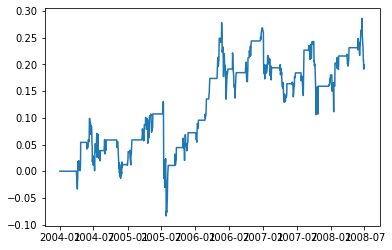

In [24]:
pairSelected = "MSFT/GENZ"
estimators = estimatorData.loc[pairSelected].tolist()

pre_trading = f_get_pre_trading(pairSelected, pairData, df_2008_inout, estimators,  30)


# OutSample
pre_trading.loc[pre_trading.index > "2008-01-01","PnL"].cumsum().tail(1)

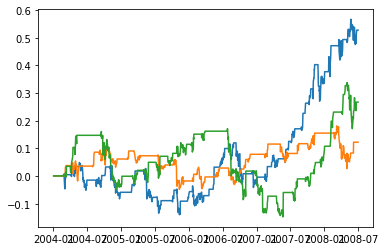

In [353]:
pre_trading_dict, portfolio_Shares = f_get_portfolio_positions(elligibility_sorted_data, 0.25, pairData, df_2008_inout, estimatorData)

#### Create dataframe pre-trading pour la pair

# Archives

#### All ticker from 1990 to 2023 : Retreive their price series

In [155]:
allTicker = nasdaq_dataConstituent_rawr["co_tic"].unique().tolist()

"""with open('allTicker.txt', 'w') as f:
    for item in allTicker:
        f.write("%s\n" % item)
        
# Open it back list :


with open('mylist.txt', 'r') as f:
    my_list = [line.rstrip() for line in f]
"""    

"\nwith open('mylist.txt', 'r') as f:\n    my_list = [line.rstrip() for line in f]\n"

#### Cleaner datas

In [180]:
stockData = pd.read_csv("/Users/sebastiencaron/Desktop/TradingClubHFT/Codes/Cointegration/data/compustatData.csv")
stockData["adjClose"] = stockData["prccd"] / stockData["ajexdi"]
stockData = stockData.iloc[:, [2, 3, 6]] # Keeps columns : date, ticker, adjClose
stockData.columns = ["date", "ticker", "adjClose"]
pivoted_df = stockData.pivot(index='date', columns='ticker', values='adjClose') # Concat all data
adjPrice = pivoted_df.loc[:, pivoted_df.columns[pivoted_df.columns.isin(allTicker)]] # Keep the right columns ticker in the list
missing_tickers = set(allTicker) - set(pivoted_df.columns) # Find the missing tickers

/var/folders/hv/1_92kz110w572ncggsb_c81c0000gp/T/ipykernel_1307/438022319.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  stockData = pd.read_csv("/Users/sebastiencaron/Desktop/TradingClubHFT/Codes/Cointegration/data/compustatData.csv")


In [ ]:
import concurrent.futures

def process_pair(pair):
    try:
        pairName_i = pairName[pair]
        print(f"Doing : {pairName_i}")
        Stock1 = pairData["Stock 1"][pair]
        Stock2 = pairData["Stock 2"][pair]
        
        dict_res = get_elligibility(Stock1, Stock2, inSample)
        
        print(f"{pairName_i}: Done")
        return pair, dict_res
    except Exception as e:
        print(f"Error with {pairName_i} and {e}")
        return pair, None

pairName = pairData["pair"]
inSample = stockPrices["inSample"]
N = len(pairName)
elligibilityData = np.zeros((N, 3))
estimationData = np.zeros((N, 5))

# Use ThreadPoolExecutor to parallelize the loop
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_pair = {executor.submit(process_pair, pair): pair for pair in range(100)}
    for future in concurrent.futures.as_completed(future_to_pair):
        pair, dict_res = future.result()
        if dict_res is not None:
            elligibilityData[pair] = dict_res["elligibility"]
            estimationData[pair] = dict_res["estimators"]